# Mouse public data alignment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scvelo as scv
import scanpy.external as sce
import anndata as ad
from scipy.sparse import csr_matrix

PROJECT_DIR = "/home/sisaev/projects/Gustafsson_et_al_2022"
DATA_DIR = "/home/sisaev/data/thymus_Karin/count"
exec(open(f"{PROJECT_DIR}/tools/tools.py").read())

paper_cmap_mouse = {
    "EC" : "#71fdea",
    "TEC A" : "#1d25f3",
    "TEC B" : "#dcae3d",
    "pcPV" : "#ae0b09",
    "aPV" : "#fda936",
    "Tuft cells" : "#a1fb73",
    "Lrrn4+" : "#f443a9",
    "MC" : "#6b04d4",
    "NC" : "#34be1e",
    "HC" : "#ff0000",
    "SM" : "#00573e",
    "Penk+ Cdh11+ MC" : "#00b3f4",
    "Cd248+ MC" : "#008af6",
    "Postn+ MC" : "#ed00ff",
    "NA" : "#aaaaaa"
}

sc.settings.verbosity = 3
sns.set(font_scale=1)
sc.settings.set_figure_params(dpi=150)
sns.set_style("white")
Reds = get_beautiful_cmap()

In [5]:
metadata_df = pd.read_csv(f"{PROJECT_DIR}/data/Mouse_Bornstein/GSE103967_metadata.txt", sep="\t")
metadata_df.index = metadata_df["Amp_batch_ID"] + "_" + metadata_df["well.1"].astype(str)

file_list = !ls $PROJECT_DIR/data/Mouse_Bornstein/GSE103967_RAW
adatas = []
for file in file_list:
    path = f"{PROJECT_DIR}/data/Mouse_Bornstein/GSE103967_RAW/{file}"
    adata = sc.read_text(path).T
    adata.obs.index = file.split(".")[0].split("_")[1] + "_" + adata.obs.index
    adatas.append(adata.copy())
    
adata = adatas[0].concatenate(adatas[1:])
adata.obs.index = [barcode.split("-")[0] for barcode in adata.obs.index]
adata.obs["batch"] = [barcode.split("_")[0] for barcode in adata.obs.index]
adata.layers["counts"] = adata.X
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs["total_counts"] >= 500]
del adatas

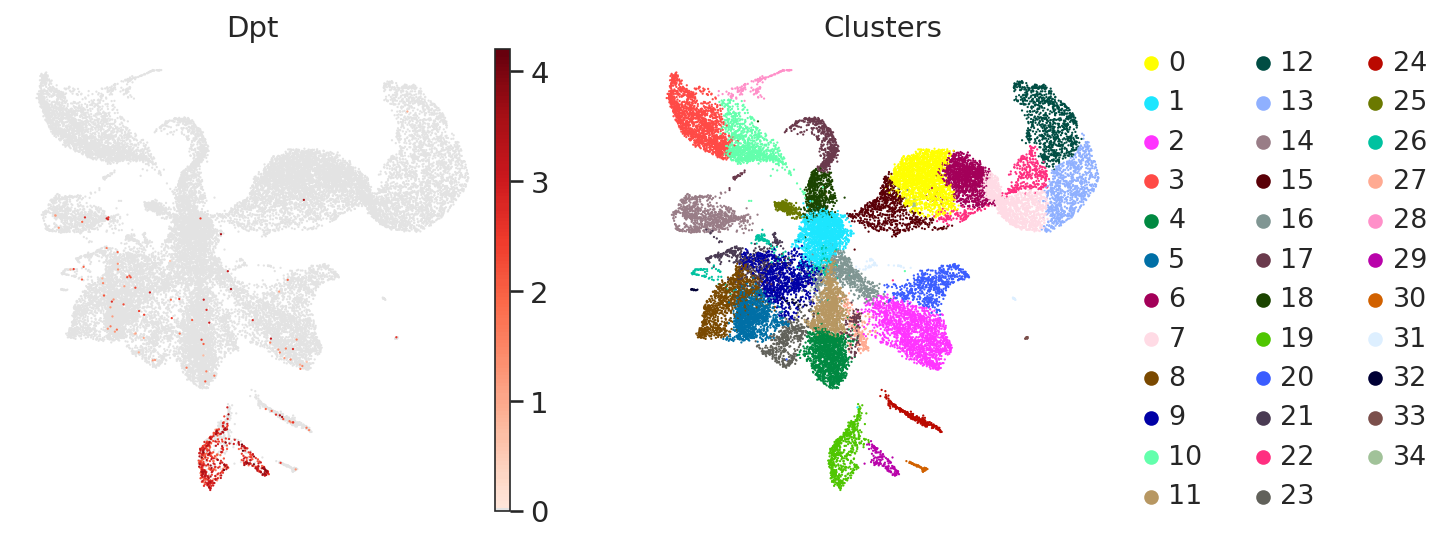

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts"
)
adata.raw = adata
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.5)

sc.pl.umap(adata, color=["Dpt", "leiden"], cmap=Reds, frameon=False, title=["Dpt", "Clusters"])

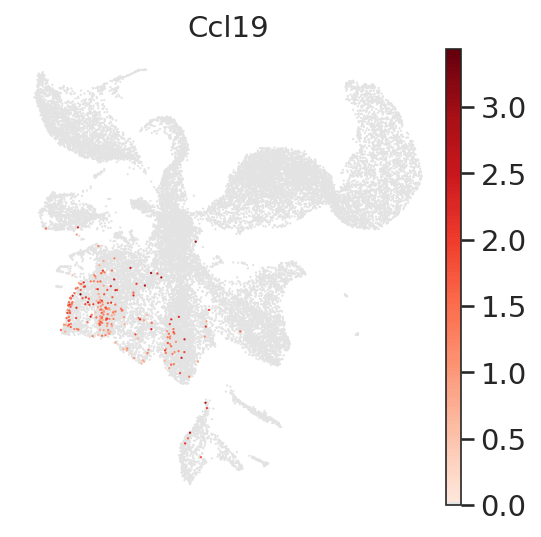

In [2]:
adata = sc.read_h5ad(f"{PROJECT_DIR}/data/Mouse_Bornstein/Mouse_AllCells.h5ad")
sc.pl.umap(adata, color=["Ccl19"], cmap=Reds, frameon=False)

In [10]:
adata.write_h5ad(f"{PROJECT_DIR}/data/Mouse_Bornstein/Mouse_AllCells.h5ad")
del adata

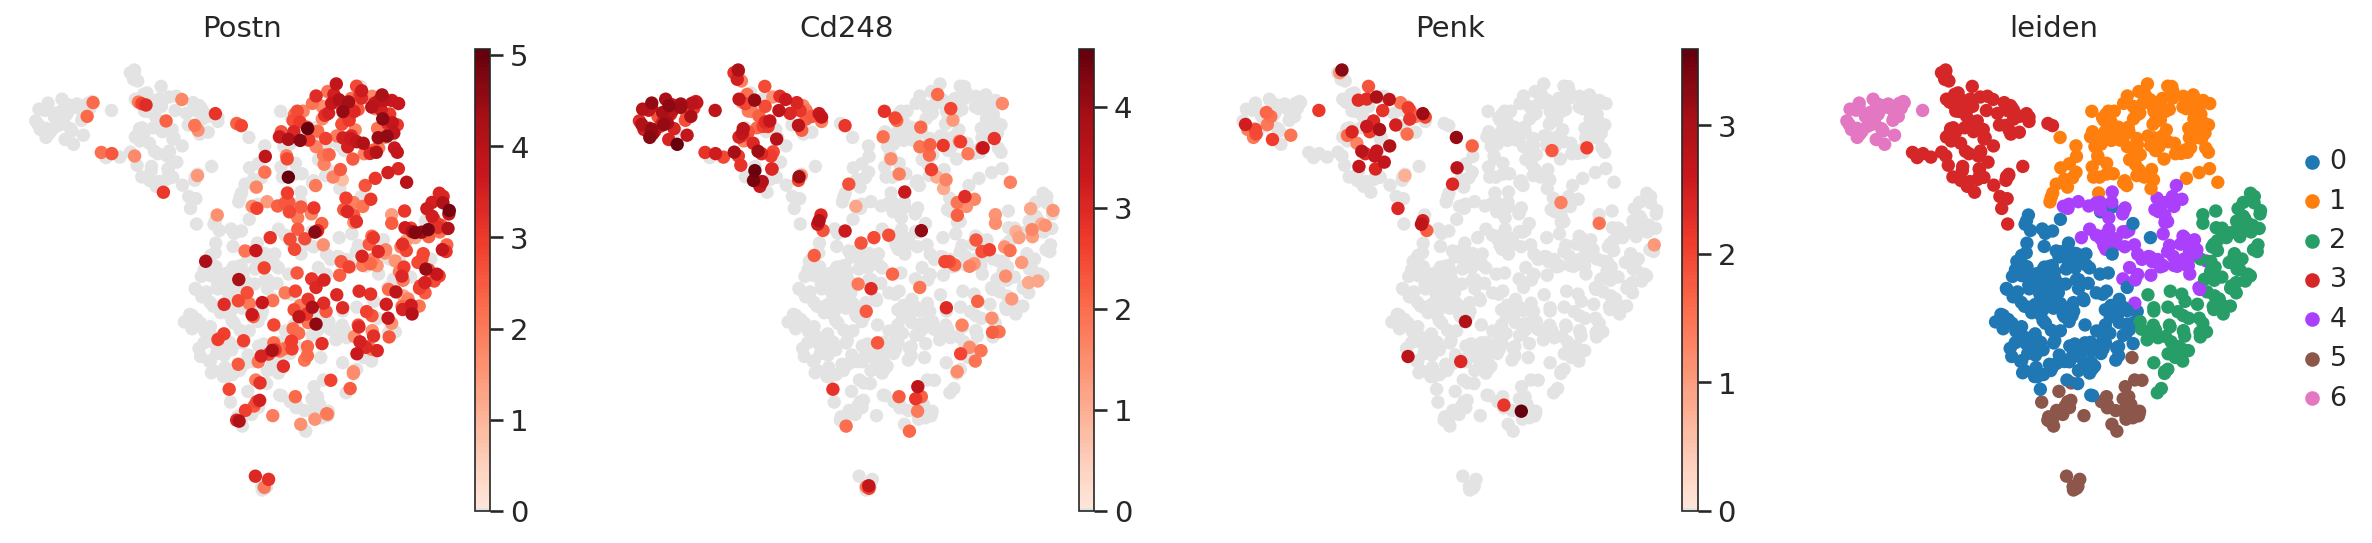

In [5]:
adata_MC = sc.read_h5ad(f"{PROJECT_DIR}/data/Mouse_Bornstein/Mouse_AllCells.h5ad")
adata_MC = adata_MC[np.isin(adata_MC.obs.leiden, ["19", "29"])]
adata_MC.X = adata_MC.layers["counts"].copy()

sc.pp.normalize_total(adata_MC, target_sum=1e4)
sc.pp.log1p(adata_MC)
sc.pp.highly_variable_genes(adata_MC, n_top_genes=1000, flavor="seurat_v3", layer="counts")
sc.pp.scale(adata_MC)
sc.tl.pca(adata_MC)

sc.pp.neighbors(adata_MC, n_pcs=15)
sc.tl.umap(adata_MC, min_dist=0.2)
sc.tl.leiden(adata_MC, resolution=0.65)

sc.pl.umap(adata_MC, color=["Postn", "Cd248", "Penk", "leiden"], frameon=False, cmap=Reds)

In [8]:
leiden_to_ct = {
    "6" : "Cd248+ MC",
    "3" : "Penk+ Cdh11+ MC",
    "0" : "Postn+ MC",
    "1" : "Postn+ MC",
    "2" : "Postn+ MC",
    "4" : "Postn+ MC",
    "5" : "Postn+ MC"
}

adata_MC.obs["cell_type_Bornstein"] = [leiden_to_ct[leiden] for leiden in adata_MC.obs.leiden]
adata_MC.obs["cell_type_Bornstein"] = adata_MC.obs["cell_type_Bornstein"].astype("category")
adata_MC.uns["cell_type_Bornstein_colors"] = [paper_cmap_mouse[ct] for ct in adata_MC.obs.cell_type_Bornstein.cat.categories]

adata_MC.write_h5ad(f"{PROJECT_DIR}/data/Mouse_Bornstein/Mouse_MC.h5ad")

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [ ]:
adata_MC = sc.read_h5ad(f"{PROJECT_DIR}/data/Mouse_Bornstein/Mouse_AllCells.h5ad")
adata_our = sc.read_h5ad(f"{PROJECT_DIR}/data/Mouse_MC_conos.h5ad")
adata_our.X = adata_our.layers["counts"].copy()

adata_MC = adata_MC[np.isin(adata_MC.obs.leiden, ["19", "29"])]
adata_MC.obs["sample_id"] = "Bornstein"
adata_MC = ad.AnnData(
    X=csr_matrix(adata_MC.layers["counts"].copy()),
    obs=adata_MC.obs,
    var=adata_MC.var
)

adata = adata_MC.concatenate(adata_our)
del adata_our

In [35]:
adata = run_conos_pagoda2(
    adata,
    tmp_dir=f"{PROJECT_DIR}/data/Mouse_Bornstein/Mouse_MC_Conos/",
    batch_key="sample_id",
    script_path=f"{PROJECT_DIR}/tools/conos_wrapper.R"
    n_hvg=1000,
    n_comps=15
)

... storing 'sample_id' as categorical


(1/3) Writing .h5ad-file
(2/3) Running wrapper (it may takes a long time)
(3/3) Reading conos outputs


... storing 'leiden' as categorical
... storing 'sample_id' as categorical
... storing 'condition' as categorical
... storing 'predicted_doublet' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_l2' as categorical


In [29]:
ct_Bornstein = []
for barcode in adata.obs.index:
    clear_barcode = barcode.split("-")[0]
    if clear_barcode in adata_MC.obs.index:
        ct_Bornstein.append(adata_MC.obs.loc[clear_barcode]["cell_type_Bornstein"])
    else:
        ct_Bornstein.append("NA")

<AxesSubplot:title={'center':'Alignment between ours and Bornstein data'}>

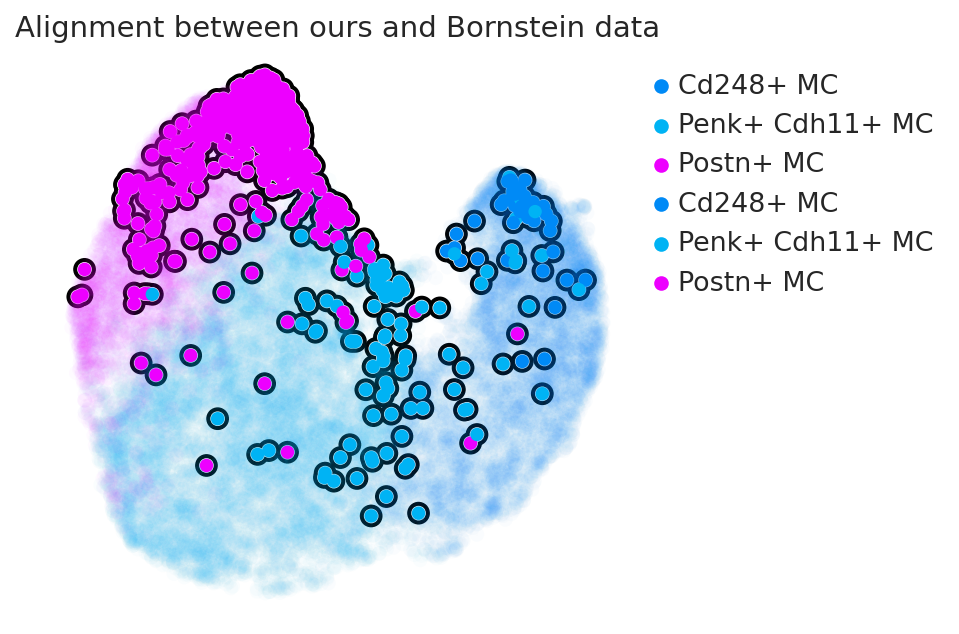

In [43]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 5))
adata.uns["cell_type_l2_colors"] = [paper_cmap_mouse[ct] for ct in adata.obs.cell_type_l2.cat.categories]
adata.obs["cell_type_Bornstein"] = ct_Bornstein
adata.obs["cell_type_Bornstein"] = adata.obs["cell_type_Bornstein"].astype("category")
adata.uns["cell_type_Bornstein_colors"] = [paper_cmap_mouse[ct] for ct in adata.obs.cell_type_Bornstein.cat.categories]

scv.pl.umap(adata, color="cell_type_l2", ax=ax, show=False, legend_loc=None, s=200, alpha=0.02)
scv.pl.umap(adata[adata.obs.sample_id == "Bornstein"], color="cell_type_Bornstein", ax=ax,
            show=False, add_outline=True, title="Alignment between ours and Bornstein data")

In [44]:
adata.write_h5ad(f"{PROJECT_DIR}/data/Mouse_Bornstein/Mouse_MC_Conos/Mouse_BornsteinOur_integration.h5ad")